In [1]:
import pandas as pd
import numpy as np
import nltk

In [4]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/skathirmani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/skathirmani/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/skathirmani/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [5]:
!pip install wordcloud

You are using pip version 10.0.1, however version 19.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### Download URL: https://github.com/skathirmani/datasets

imdb_sentiment.csv

In [6]:
imdb = pd.read_csv('/datasets/imdb_sentiment.csv')

In [7]:
imdb.head()

,review,sentiment
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [8]:
imdb['sentiment'].value_counts()

1    386
0    362
Name: sentiment, dtype: int64

# Bag of words analysis

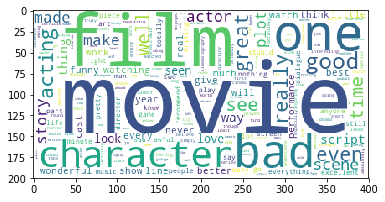

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

input_string = ' '.join(imdb['review'])
wc = WordCloud(background_color='white').generate(input_string)
plt.imshow(wc)

## Text Cleaning
- Convert every character to lower case 
- Remove junk characters
- Remove commonly used words
- Identify root of the words (play, playing, plays, played)

In [22]:
docs = imdb['review'].str.lower().str.replace('[^a-z ]', '')

In [27]:
stopwords = nltk.corpus.stopwords.words('english')
len(stopwords)
stopwords[:5]

['i', 'me', 'my', 'myself', 'we']

In [32]:
stemmer = nltk.stem.PorterStemmer()
stemmer.stem('organization')

'organ'

In [37]:
docs_clean = []
for doc in docs.head(2):
    words = doc.split(' ')
    #print(doc)
    #print(words)
    words_clean = []
    for word in words:
        if word not in stopwords:
            words_clean.append(stemmer.stem(word))
    
    doc_clean = ' '.join(words_clean)
    docs_clean.append(doc_clean)
    
print(docs_clean)

['slowmov aimless movi distress drift young man  ', 'sure lost  flat charact audienc nearli half walk  ']


In [64]:
docs = imdb['review'].str.lower().str.replace('[^a-z ]', '')

def clean_sentence(text):
    words = text.split(' ')
    words_clean = [stemmer.stem(word) for word in words if word not in stopwords]
    return ' '.join(words_clean)
docs_clean = docs.apply(clean_sentence)
#docs_clean.head(1)

## Document Term Matrix

In [65]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(docs_clean)
dtm = vectorizer.transform(docs_clean)
dtm

<748x2475 sparse matrix of type '<class 'numpy.int64'>'
	with 6797 stored elements in Compressed Sparse Row format>

In [46]:
docs_clean.shape

(748,)

In [49]:
no_of_zeros = (748 * 2475) - 6797
sparsity = (no_of_zeros) / (748*2475) * 100
sparsity

99.63285259007183

In [66]:
df_dtm = pd.DataFrame(dtm.toarray(),
                     columns = vectorizer.get_feature_names())
(df_dtm == 0).sum().sum()

1844503

In [55]:
(748*2475) - 1844503

6797

In [68]:
df_dtm.sum().sort_values(ascending=False).head(2)

movi    207
film    184
dtype: int64

In [71]:
df_dtm.sum(axis=1).sort_values(ascending=False).head(1)

136    686
dtype: int64

In [72]:
from sklearn.model_selection import train_test_split
train_x, test_x = train_test_split(df_dtm,
                                   test_size=0.2,
                                   random_state=100)

In [75]:
train_y = imdb.iloc[train_x.index]['sentiment']
test_y  = imdb.iloc[test_x.index]['sentiment']

In [77]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf_model = RandomForestClassifier(random_state=100, n_estimators=300)
rf_model.fit(train_x, train_y)
rf_predict_class = rf_model.predict(test_x)
accuracy_score(test_y, rf_predict_class)

0.72

In [78]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB
model = GaussianNB()
model.fit(train_x, train_y)
predict_class = model.predict(test_x)
accuracy_score(test_y, predict_class)

0.5933333333333334

In [79]:
model = MultinomialNB()
model.fit(train_x, train_y)
predict_class = model.predict(test_x)
accuracy_score(test_y, predict_class)

0.7733333333333333

## TF-IDF Vectorization

In [87]:
from sklearn.feature_extraction.text import TfidfVectorizer
train, test = train_test_split(docs_clean, test_size=0.2, random_state=100)
tfidf = TfidfVectorizer()
tfidf.fit(train)
train_dtm_tfidf = tfidf.transform(train)
test_dtm_tfidf = tfidf.transform(test)

df_train_tfidf = pd.DataFrame(train_dtm_tfidf.toarray(),
                              columns=tfidf.get_feature_names())
df_test_tfidf = pd.DataFrame(test_dtm_tfidf.toarray(),
                              columns=tfidf.get_feature_names())


train_y = imdb.iloc[df_train_tfidf.index]['sentiment']
test_y = imdb.iloc[df_test_tfidf.index]['sentiment']
rf_model = RandomForestClassifier(random_state=100,
                                  n_estimators=300)
rf_model.fit(df_train_tfidf, train_y)
rf_predict_class = rf_model.predict(df_test_tfidf)
accuracy_score(test_y, rf_predict_class)

0.4866666666666667

In [91]:
sparse = pd.SparseDataFrame(df_test_tfidf)

In [95]:
from scipy.sparse import csr_matrix
csr_matrix(df_dtm)

<748x2475 sparse matrix of type '<class 'numpy.int64'>'
	with 6797 stored elements in Compressed Sparse Row format>

### Exercise : Tweets Clustering
- Using `Narendra Modi's` tweets data, identify minimum and maximum date from `created_at` column
- Create word cloud using all the rows from `text` column
- Clean the `text` column
    - Convert all characters to lower case
    - Apply regular expressions to retain only `alphabets`, `#`, `@` and `spaces`
    - Remove stop words
    - Apply stemming
- Create the `Document Term Matrix` using `CountVectorizer`; Set `min_df=5`
- Using KMeans algorithm, cluster the tweets in to 4 groups
- Create word cloud for each group